In [1]:
# importing the required libraries
import pandas as pd
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# reading the dataset contating image path and label
df = pd.read_csv('dataset/details.csv')

In [3]:
# dropping the unnecessory column
df = df.drop('Unnamed: 0', axis=1)

In [4]:
# first 5 rows of dataset
df.head()

,image,classes
0,image/0.jpeg,unknown
1,image/1.jpeg,head_lamp
2,image/2.jpeg,door_scratch
3,image/3.jpeg,head_lamp
4,image/4.jpeg,unknown


## Exploring Dataset and Images

<AxesSubplot:xlabel='classes', ylabel='count'>

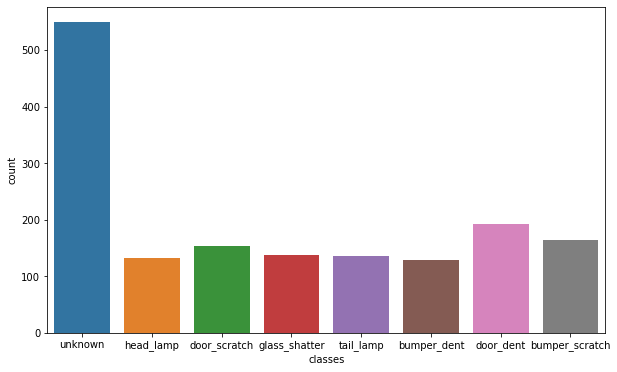

In [5]:
# These are the 8 labels that images are associated with

plt.figure(figsize=(10, 6))
sns.countplot(x=df['classes'], linewidth=15)

# most of the images belong to the unknown label

In [6]:
# making a dictionary of all the classes so that we could add labels as numerical data

classes = list(df.classes.unique())

class_dict = {}
for i in range(0, len(classes)):
    class_dict[classes[i]] = i

In [7]:
# encoding for each classes
class_dict

{'unknown': 0,
 'head_lamp': 1,
 'door_scratch': 2,
 'glass_shatter': 3,
 'tail_lamp': 4,
 'bumper_dent': 5,
 'door_dent': 6,
 'bumper_scratch': 7}

In [8]:
# for storing images
X = []

# for storing labels
y = []

for index, row in df.iterrows():
    x = cv2.imread('dataset/' + row[0], cv2.IMREAD_COLOR)
    x = np.array(x)
    x = x/255
    X.append(x)
    y.append(class_dict[row[1]])

In [9]:
X = np.array(X)

In [10]:
y = np.array(y)

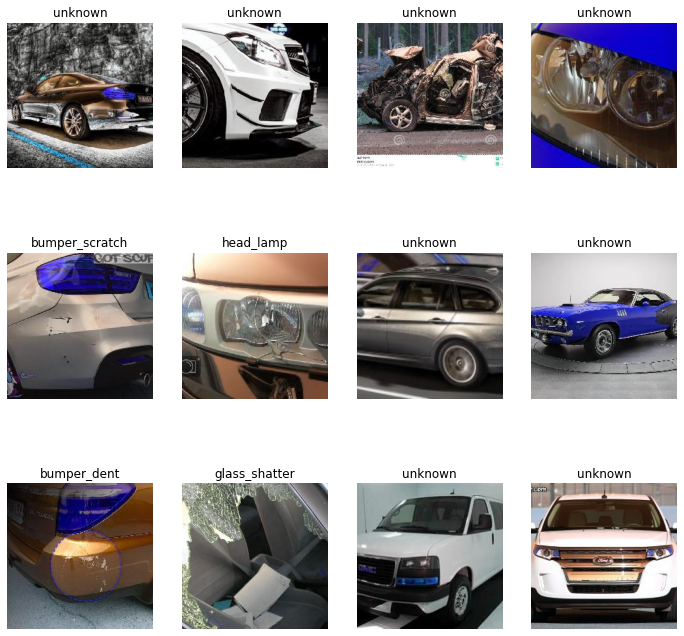

In [11]:
plt.figure(figsize=(12, 12))

for i in range(12):
    g = random.randint(0, len(y))
    ax = plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(X[g])
    plt.title(classes[y[g]])

## Splitting the dataset for training and testing

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# We have splitted our data in a way that - 
# 1. The samples are shuffled
# 2. The samples are stratified (the ratio of each class is maintained)
# 3. We get same samples every time we split our data (random state)

# 80% data is taken for training
# 10% for validation
# 10% for testing

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.50, stratify=y_val, shuffle=True, random_state=123)

In [14]:
# to save memory for training
del X
del y

## Image Augmentation
Augmentation is the process of creating new training samples by altering the available data. <br>
It not only increases the number of samples for training the model but also prevents the model from overfitting the training data since it makes relevant feautes in the image location invariant. <br>
We have applied horizontal and vertical flip randomly to some of our images (excluding 'unknown' images). <br>
This would also help us tackle class imbalance in our dataset

In [15]:
X_aug = []
y_aug = []

for i in range(0, len(y_train)):
    if(y_train[i]!=0): # skipping images with 'unknown' label
        t = random.randint(1, 2)
        if t==1:
            X_new = np.fliplr(X_train[i])
            X_aug.append(X_new)
            y_aug.append(y_train[i])
        else:
            X_new = np.flipud(X_train[i])
            X_aug.append(X_new)
            y_aug.append(y_train[i])

In [16]:
X_aug = np.array(X_aug)

In [17]:
X_aug.shape

(836, 224, 224, 3)

In [18]:
X_train = np.append(X_train, X_aug, axis=0) # appending augmented images to original training samples
X_train.shape

(2111, 224, 224, 3)

In [19]:
y_aug = np.array(y_aug)

In [20]:
y_train = np.append(y_train, y_aug, axis=0) # appending augmented images to original training samples
y_train.shape

(2111,)

In [21]:
# to save memory for training
del X_aug
del y_aug

## Training the Model

In [22]:
from tensorflow.keras.applications import MobileNetV2

basemodel = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')

basemodel.trainable = False

In [23]:
inputs = basemodel.input
x = Dense(224, activation='relu')(basemodel.output)
x = Dropout(0.4)(x)
x = Dense(112, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(8, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [25]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=10e-3), metrics= ["accuracy"])

In [26]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="vehicle_weights.h5", verbose=1, save_best_only=True)

In [27]:
history = model.fit(X_train, y_train, epochs = 100, validation_data=(X_val, y_val), shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
66/66 [==============================] - 14s 94ms/step - loss: 2.1325 - accuracy: 0.3742 - val_loss: 1.1188 - val_accuracy: 0.5750

Epoch 00001: val_loss improved from inf to 1.11877, saving model to vehicle_weights.h5


C:\Users\kanak\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
66/66 [==============================] - 4s 67ms/step - loss: 1.2486 - accuracy: 0.5514 - val_loss: 0.9406 - val_accuracy: 0.6438

Epoch 00002: val_loss improved from 1.11877 to 0.94060, saving model to vehicle_weights.h5
Epoch 3/100
66/66 [==============================] - 4s 68ms/step - loss: 1.0633 - accuracy: 0.6101 - val_loss: 0.9073 - val_accuracy: 0.6687

Epoch 00003: val_loss improved from 0.94060 to 0.90728, saving model to vehicle_weights.h5
Epoch 4/100
66/66 [==============================] - 4s 67ms/step - loss: 0.9951 - accuracy: 0.6485 - val_loss: 0.9539 - val_accuracy: 0.6812

Epoch 00004: val_loss did not improve from 0.90728
Epoch 5/100
66/66 [==============================] - 4s 67ms/step - loss: 1.0001 - accuracy: 0.6509 - val_loss: 0.9321 - val_accuracy: 0.6562

Epoch 00005: val_loss did not improve from 0.90728
Epoch 6/100
66/66 [==============================] - 4s 67ms/step - loss: 0.9924 - accuracy: 0.6476 - val_loss: 0.9364 - val_accuracy: 0.6750

E

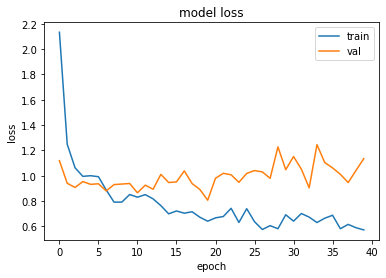

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

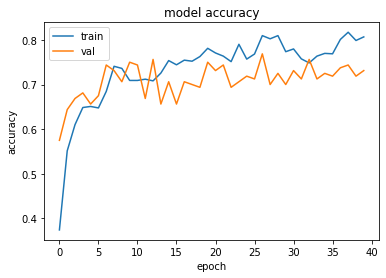

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("vehicle_model.json","w") as json_file:
  json_file.write(model_json)

## Testing the trained model

In [31]:
# loding the model (best saved one)

with open('vehicle_model.json', 'r') as json_file:
    json_savedModel = json_file.read()

# load the model architecture
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('vehicle_weights.h5')
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [32]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 2s 72ms/step - loss: 0.6763 - accuracy: 0.7673


[0.6763005256652832, 0.7672955989837646]

In [33]:
# making predictions
predictions = model.predict(X_test)

In [34]:
# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

In [35]:
# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

0.7672955974842768

<AxesSubplot:>

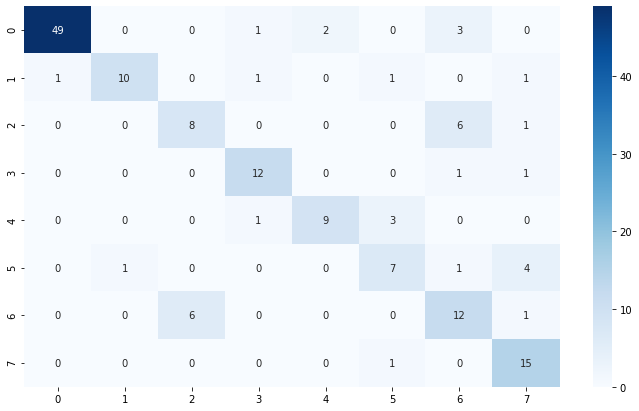

In [36]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, cmap='Blues')


In [37]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.89      0.93        55
           1       0.91      0.71      0.80        14
           2       0.57      0.53      0.55        15
           3       0.80      0.86      0.83        14
           4       0.82      0.69      0.75        13
           5       0.58      0.54      0.56        13
           6       0.52      0.63      0.57        19
           7       0.65      0.94      0.77        16

    accuracy                           0.77       159
   macro avg       0.73      0.72      0.72       159
weighted avg       0.79      0.77      0.77       159

